In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv

In [2]:
def plot_column(df, column, color):
    plt.figure(figsize=(10, 6))
    plt.plot(df['Ano'], df[column], color=color)
    plt.xlabel('Ano')
    plt.ylabel(column)
    plt.title(f'{column}')
    plt.grid(True)
    plt.show()

In [3]:
df = pd.read_csv('pib_roraima.csv')
df

,Ano,Roraima - PIB - Estadual,Roraima - PIB - Construção Civil,Roraima - PIB - Per Capita,Roraima - PIB - Preços de Mercado
0,1985,3.225110e-04,121639.466852,12.075208,1.715030e+06
1,1986,1.053997e-03,137949.941876,12.076733,1.870807e+06
2,1987,3.424649e-03,127476.357733,12.527497,2.099709e+06
3,1988,2.594810e-02,145593.174404,12.871072,2.317346e+06
4,1989,4.478351e-01,147413.758795,11.436140,2.396214e+06
5,1990,1.295053e+01,106775.525690,11.289617,2.499589e+06
6,1991,5.654765e+01,136014.567056,11.451570,2.668319e+06
7,1992,5.457809e+02,149828.324579,11.365964,2.760440e+06
8,1993,9.591467e+03,162407.006972,11.319846,2.870362e+06
9,1994,2.384589e+05,192144.171750,11.250586,2.971955e+06


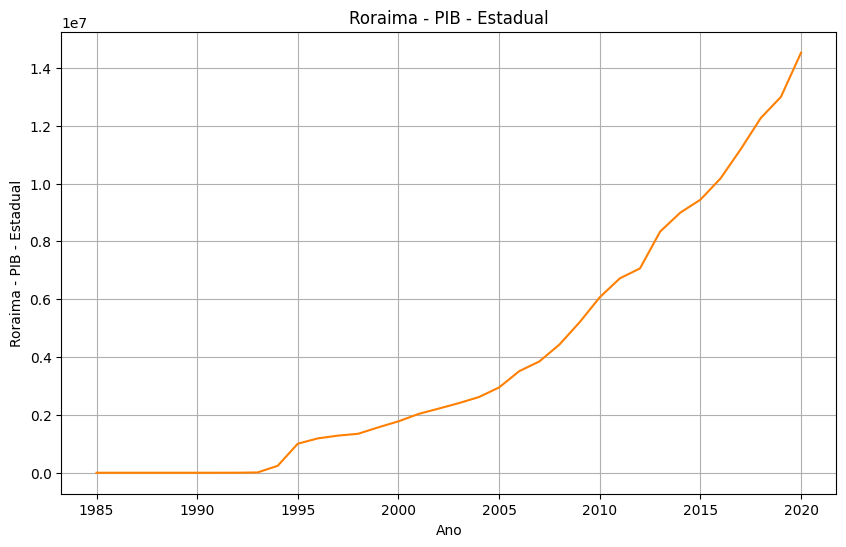

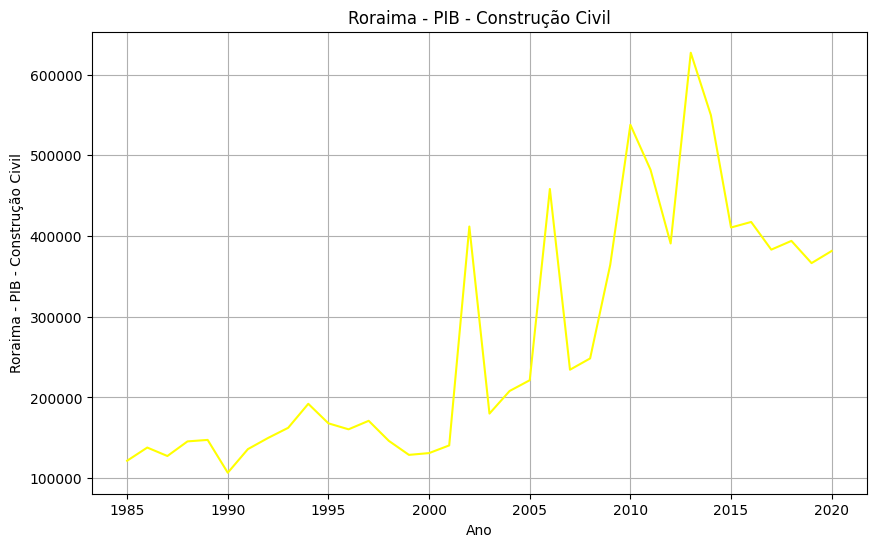

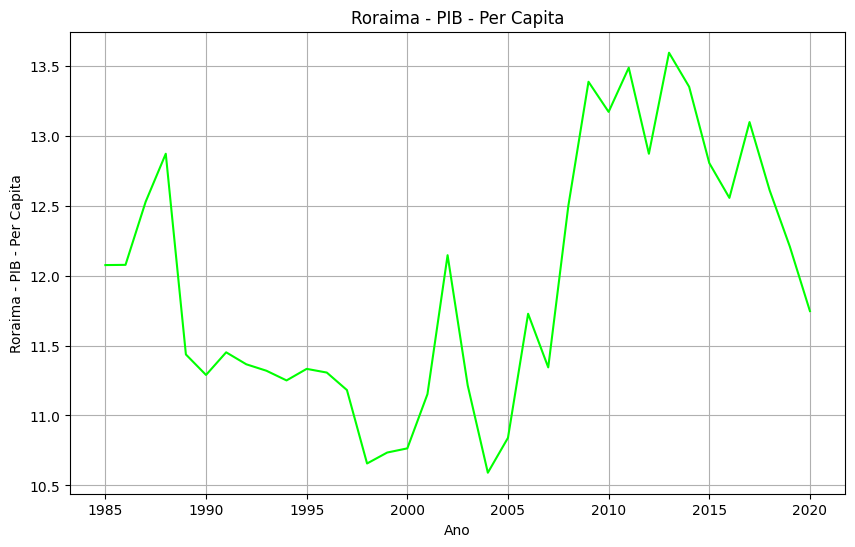

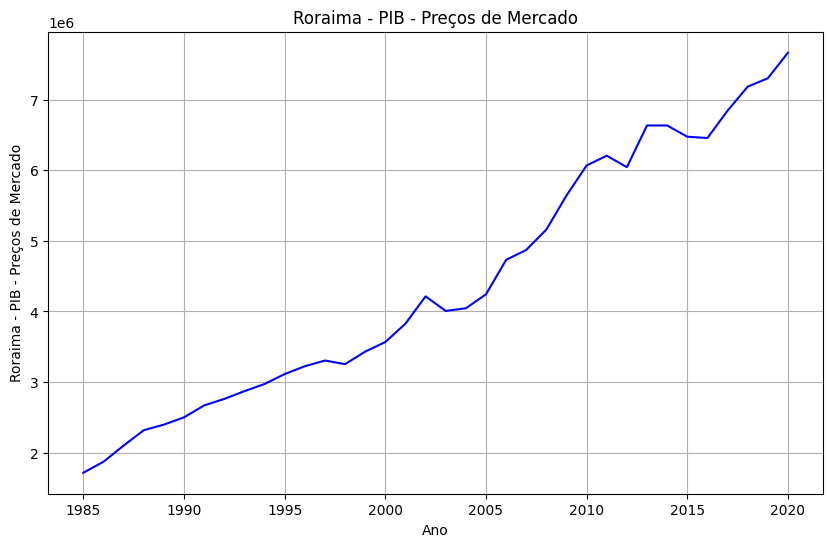

In [4]:
colors = ['#FF0000', '#FF7F00', '#FFFF00', '#00FF00', '#0000FF', '#4B0082', '#8B00FF', '#9400D3', '#FF00FF']
for i, column in enumerate(df.columns):
    if i > 0:
        plot_column(df, column, color=colors[i])